In [1]:
# https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

In [2]:
from transformers import BertModel
from transformers import BertTokenizer
import torch

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors
import swifter

from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.types import *

from time import asctime

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.annotator.embeddings import *
from pyspark.sql.functions import col

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
asctime()

'Fri Apr 28 20:03:51 2023'

In [ ]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '16g'), 
                                   ('spark.executor.cores', '3'), 
                                   ('spark.cores.max', '3'), 
                                   ('spark.driver.memory', '16G'),
                                   ("spark.serializer", "org.apache.spark.serializer.KryoSerializer"),
                                   ("spark.kryoserializer.buffer.max", "2000M"),
                                   ("spark.driver.maxResultSize", "0"),
                                   ("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.1")
                                  ])

spark = SparkSession \
    .builder \
    .appName("tings") \
    .master("local[*]") \
    .config(conf=conf) \
    .getOrCreate()

In [487]:
spark_df = spark.read.csv('../data/master-thesis-dataset-large-label-processedtext-only.csv',
                    sep="|",
                    inferSchema=True,                     
                    header=True)

#questions_df = spark.read.csv("../data/questions.csv", header=True, inferSchema=True)
questions_df = pd.read_csv("../data/questions.csv")
questions = questions_df.processed_question_str

In [488]:
spark_df.show(5)

+--------------------+-------------------+
|  processed_text_str|              Label|
+--------------------+-------------------+
|light_yellow citr...|France Chenin Blanc|
|top_quality grape...|  France Pinot Noir|
|young good 42 pot...|     Italy Nebbiolo|
|great balance alc...|France Chenin Blanc|
|limited experienc...|   Italy Sangiovese|
+--------------------+-------------------+
only showing top 5 rows



In [489]:
spark_df.printSchema()

root
 |-- processed_text_str: string (nullable = true)
 |-- Label: string (nullable = true)



In [490]:
data = spark_df.groupby('Label').count()

In [496]:
data.show(10)

[Stage 73:=============================>                            (2 + 2) / 4]

+--------------------+-----+
|               Label|count|
+--------------------+-----+
|    Argentina Merlot|   65|
|   Portugal Malvasia| 1008|
|France Melon de B...| 1139|
|       Portugal Baga|  152|
|  Germany Chardonnay|   47|
|United States Rie...| 2561|
|New Zealand Sauvi...| 4073|
|South Africa Pino...|   70|
|France Sauvignon ...| 2760|
|   France Pinot Noir| 6816|
+--------------------+-----+
only showing top 10 rows



In [493]:
data_pandas = data.toPandas()
data_pandas_large = data_pandas[data_pandas['count'] > 600]
data_pandas_small = data_pandas[data_pandas['count'] <= 600]

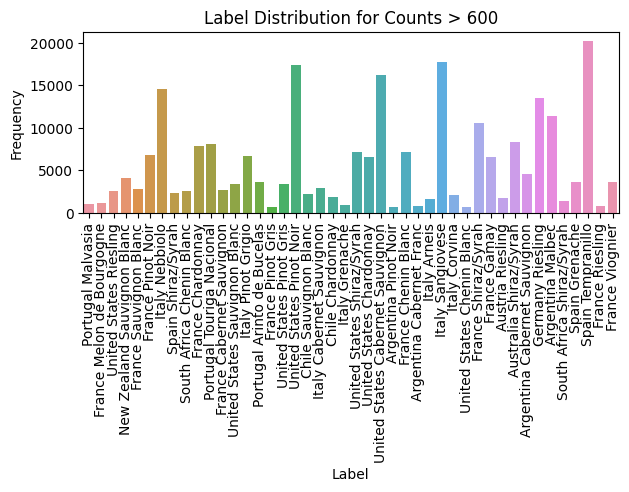

In [494]:
sns.barplot(data=data_pandas_large
            ,x='Label'
            ,y='count'
           )

plt.ylabel("Frequency")
plt.xlabel("Label")
plt.xticks(rotation=90) 
plt.tight_layout()
plt.title("Label Distribution for Counts > 600")
plt.show()

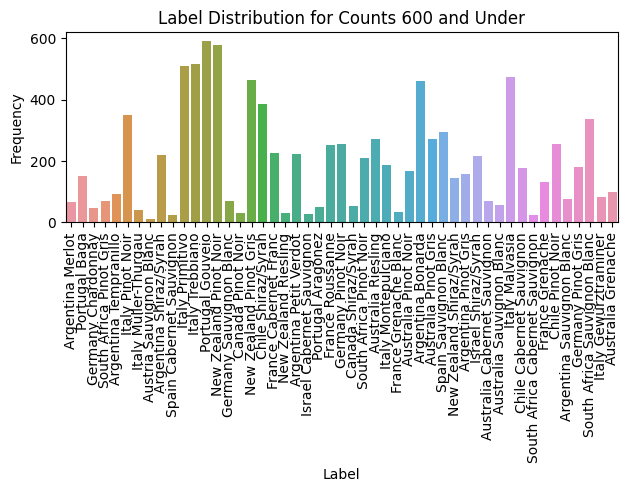

In [495]:
sns.barplot(data=data_pandas_small
            ,x='Label'
            ,y='count'
           )

plt.ylabel("Frequency")
plt.xlabel("Label")
plt.xticks(rotation=90) 
plt.tight_layout()
plt.title("Label Distribution for Counts 600 and Under")
plt.show()

In [69]:
df.show(1)

+--------------------+--------------+
|  processed_text_str|         Label|
+--------------------+--------------+
|cascina ballarin ...|Italy Nebbiolo|
+--------------------+--------------+
only showing top 1 row



In [200]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens') # use on redused dimensionality:SentenceTransformer('all-mpnet-base-v2') longer max sequence length.. all-roberta-large-v1??
sentence_embeddings = sbert_model.encode(questions[0])
print(len(sentence_embeddings))

# similarity with itself for poc
sim_mat = cosine_similarity(sentence_embeddings.reshape(1, -1), sentence_embeddings.reshape(1, -1))
print(sim_mat)

768
[[1.]]


In [101]:
#for testing
#df = pd.read_csv("../data/master-thesis-dataset-large-label-processedtext-only-subset.csv", sep="|")
#df['bert_emb'] = df['processed_text_str'].apply(lambda xyz: sbert_model.encode(xyz))
#df

#cosine_similarity(sbert_model.encode(questions[2]).reshape(1, -1), df.bert_emb.iloc[0].reshape(1, -1)) # should be somewhat high
#cosine_similarity(sbert_model.encode(questions[2]).reshape(1, -1), df.bert_emb.iloc[1].reshape(1, -1)) <-- should be highest in subset
#cosine_similarity(sbert_model.encode(questions[2]).reshape(1, -1), df.bert_emb.iloc[2].reshape(1, -1))

,processed_text_str,Label,bert_emb
0,cascina ballarin bussia always modern interpre...,Italy Nebbiolo,"[-0.61870694, 1.0566288, -0.15238409, 0.262015..."
1,aromas blackberry_black_cherry toasted_oak min...,United States Cabernet Sauvignon,"[-0.80405974, 0.8375404, -0.5551009, 0.1099087..."
2,strong oak nose dusty dry bake_apple_pie 89_point,United States Chardonnay,"[-0.6414356, 1.8137333, -1.0508475, 0.17644694..."


In [ ]:
df = pd.read_csv("../data/master-thesis-dataset-large_specChars_rm_and_wo_foods_or_keywords_wbigrams_label.csv")

In [202]:
df['bert_emb'] = df['processed_text_str'].apply(lambda xyz: sbert_model.encode(xyz)) # takes a few hours

In [204]:
# Reshape
df['bert_emb_reshaped'] = df['bert_emb'].apply(lambda xyz: xyz.reshape(1, -1))

## Cosine Similarity Results

In [215]:
questions_df.question.iloc[0]

'I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [214]:
q1_embed = sbert_model.encode(questions[0]).reshape(1, -1)
df['q1_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q1_embed, xyz)[0][0])

In [353]:
pd.options.display.float_format = "{:,.2f}".format

In [422]:
df.sort_values('q1_cosine_similarity', ascending=False).head(20)[['q1_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q1_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
42922,0.82,United States Shiraz/Syrah,Ballard Canyon,Stolpman Vineyards Rosé 2020,22.99,56.07,Rosé
58646,0.81,France Pinot Noir,Échezeaux Grand Cru,Jean-Marc Millot Echézeaux Grand Cru 2018,265.83,283.79,Red
170011,0.79,Spain Tempranillo,Rioja,Viñedos de Páganos El Puntido 2004,106.33,71.92,Red
144600,0.79,Germany Riesling,Nahe,Korrell Riesling Auslese Paradies 2017,39.00,59.76,White
209484,0.78,France Chenin Blanc,Saumur,Domaine Arnaud Lambert Saumur 'Clos de Midi' 2018,24.00,53.08,White
152094,0.77,United States Cabernet Sauvignon,Napa Valley,Jurisdiction Cabernet Sauvignon 2018,109.97,147.40,Red
81165,0.77,United States Sauvignon Blanc,Yountville,Ghost Block Morgaenlee Vineyard Sauvignon Blan...,19.99,69.45,White
45082,0.77,Spain Tempranillo,Rioja,Artadi Grandes Añadas Rioja 2001,299.00,79.28,Red
173508,0.77,New Zealand Sauvignon Blanc,Marlborough,Tokoeka Estate Sauvignon Blanc 2021,9.98,19.84,White
154457,0.77,United States Pinot Noir,Sta. Rita Hills,Dragonette Radian Vineyard Pinot Noir 2018,80.00,84.65,Red


In [217]:
questions_df.question.iloc[1]

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [220]:
q2_embed = sbert_model.encode(questions[1]).reshape(1, -1)
df['q2_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q2_embed, xyz)[0][0])

In [421]:
df.sort_values('q2_cosine_similarity', ascending=False).head(20)[['q2_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q2_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
60563,0.88,Italy Sangiovese,Chianti,Terre di Bo Chianti Riserva 2016,14.00,37.52,Red
144149,0.88,Italy Cabernet Sauvignon,Toscana,Tenuta Luce Luce 2010,285.00,190.24,Red
135420,0.87,Italy Grenache,Cannonau di Sardegna,Pala I Fiori Cannonau 2019,18.99,26.29,Red
32280,0.87,Italy Sangiovese,Brunello di Montalcino,Terralsole Riserva Brunello di Montalcino 2010,87.00,104.87,Red
199121,0.87,Italy Sangiovese,Chianti,Terreno Chianti Classico Riserva 1997,51.99,50.18,Red
130951,0.87,France Shiraz/Syrah,Tavel,Château de Trinquevedel Tavel 2020,60.00,56.87,Rosé
33848,0.86,United States Pinot Noir,Los Carneros,Annabella Pinot Noir (Special Selection) 2020,16.99,57.53,Red
127098,0.86,Italy Nebbiolo,Barolo,Giacomo Grimaldi Ravera Barolo 2016,70.00,127.37,Red
232396,0.86,Italy Pinot Grigio,delle Venezie,La Gondola Pinot Grigio 2020,5.99,12.86,White
175298,0.86,Italy Sangiovese,Chianti,Cavaliere d'Oro Chianti 2021,11.99,37.34,Red


In [218]:
questions_df.question.iloc[2]

'I like Cabernets from Napa Valley'

In [221]:
q3_embed = sbert_model.encode(questions[2]).reshape(1, -1)
df['q3_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q3_embed, xyz)[0][0])

In [420]:
df.sort_values('q3_cosine_similarity', ascending=False).head(20)[['q3_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q3_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
11299,0.83,United States Cabernet Sauvignon,Mount Veeder,Mithra Cabernet Sauvignon 2009,199.99,171.22,Red
154650,0.81,Argentina Cabernet Sauvignon,Lujan de Cuyo,Viña Cobos Bramare Cabernet Sauvignon 2017,39.95,115.80,Red
142363,0.80,United States Shiraz/Syrah,North Coast,Relic Scarpa Syrah 2015,49.99,95.94,Red
144798,0.78,United States Cabernet Sauvignon,Oakville,Nickel & Nickel Air Show Vineyard Cabernet Sau...,145.00,187.38,Red
44787,0.77,Italy Primitivo,Puglia,Tenute Quattro Conti Cinque Secoli Primitivo M...,21.99,28.19,Red
39884,0.76,Italy Sangiovese,Brunello di Montalcino,La Fiorita Brunello di Montalcino 2008,55.00,96.86,Red
61107,0.74,Australia Shiraz/Syrah,Barossa Valley,Two Hands Gnarly Dudes Shiraz 2018,34.99,88.55,Red
39935,0.74,United States Shiraz/Syrah,Rutherford,Inglenook RC Reserve 2013,97.99,111.90,Red
67498,0.74,United States Sauvignon Blanc,Sonoma County,Cattleya Alma de Cattleya Sauvignon Blanc 2021,23.99,45.88,White
41158,0.74,United States Cabernet Sauvignon,Rutherford,Peju Cabernet Sauvignon Reserve 2015,140.70,137.19,Red


In [219]:
questions_df.question.iloc[3]

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [ ]:
q4_embed = sbert_model.encode(questions[3]).reshape(1, -1)
df['q4_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q4_embed, xyz)[0][0])

In [419]:
df.sort_values('q4_cosine_similarity', ascending=False).head(20)[['q4_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q4_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
60701,0.82,New Zealand Sauvignon Blanc,Marlborough,The Seeker Sauvignon Blanc 2020,11.99,20.08,White
97184,0.82,Italy Pinot Grigio,Valdadige,Cavit Collection Pinot Grigio 2018,15.99,17.59,White
178116,0.81,Portugal Arinto de Bucelas,Douro,Monte Cascas Colheita Douro Branco 2016,7.09,23.14,White
33652,0.81,Italy Nebbiolo,Langhe,Gaja Darmagi Langhe 2013,224.98,194.52,Red
219746,0.81,France Chardonnay,Criots-Bâtard-Montrachet Grand Cru,Fontaine-Gagnard Criots-Bâtard-Montrachet Gran...,495.00,278.16,White
17202,0.80,United States Chardonnay,Los Carneros,Acacia Carneros Chardonnay 2016,40.99,67.71,White
106037,0.80,Italy Nebbiolo,Barolo,Castello di Verduno Barolo Massara 2017,99.00,144.45,Red
127045,0.80,Germany Riesling,Piesport,Julian Haart Piesporter 2017,38.00,45.51,White
247861,0.80,Spain Grenache,Penedès,Viladellops Garnatxa 2018,18.17,41.14,Red
66192,0.79,Spain Shiraz/Syrah,Montsant,AT Roca Sileo 2020,22.99,46.79,Red


In [223]:
questions_df.question.iloc[4]

"I don't know what I want."

In [ ]:
q5_embed = sbert_model.encode(questions[4]).reshape(1, -1)
df['q5_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q5_embed, xyz)[0][0])

In [418]:
df.sort_values('q5_cosine_similarity', ascending=False).head(20)[['q5_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q5_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
151987,0.89,United States Cabernet Sauvignon,Napa Valley,Pine Ridge Fortis Cabernet Sauvignon 2015,229.99,152.41,Red
226055,0.89,Chile Chardonnay,Casablanca Valley,Casillero del Diablo Chardonnay (Reserva) 2018,9.99,49.86,White
93209,0.88,Spain Sauvignon Blanc,Castilla,Pinuaga Sauvignon Bianco 2019,14.99,22.51,White
96627,0.86,Portugal Arinto de Bucelas,Vinho Verde,Quinta do Ameal Branco (Loureiro) 2020,20.42,18.40,White
93174,0.86,Italy Sangiovese,Chianti,Poggio Bonelli Villa Chigi Saracini Chianti 2021,19.99,42.91,Red
5534,0.85,United States Pinot Noir,Sonoma County,Scherrer Pinot Noir 2016,38.99,74.64,Red
141279,0.84,South Africa Chenin Blanc,Swartland,Intellego The Story of Harry 2020,21.98,43.39,White
139441,0.84,Spain Tempranillo,Toro,Bodega Numanthia Termanthia 2007,195.00,65.28,Red
179471,0.84,Spain Tempranillo,Ribera del Duero,Goyo Garcia Viadero Finca Viñas de Arcilla 2012,65.00,63.01,Red
139340,0.83,United States Chardonnay,Napa Valley,Volunteer Chardonnay 2019,20.00,96.54,White


In [225]:
questions_df.question.iloc[5]

'Do you have a red wine that is light? Not too heavy.'

In [231]:
q6_embed = sbert_model.encode(questions[5]).reshape(1, -1)
df['q6_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q6_embed, xyz)[0][0])

In [417]:
df.sort_values('q6_cosine_similarity', ascending=False).head(20)[['q6_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q6_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
129602,0.91,United States Cabernet Sauvignon,Rutherford,Nickel & Nickel Quarry Vineyard Cabernet Sauvi...,109.95,155.66,Red
10385,0.84,Spain Tempranillo,Rioja,La Maldita Garnacha 2018,18.99,42.59,Red
141450,0.84,South Africa Shiraz/Syrah,Western Cape,Savage Red 2020,47.60,49.67,Red
45055,0.83,Australia Cabernet Sauvignon,South Australia,Penfolds Bin 707 Cabernet Sauvignon 2018,475.00,123.97,Red
194788,0.83,France Pinot Noir,Clos Vougeot Grand Cru,Haegelen-Jayer Vieilles Vignes Clos de Vougeot...,830.00,429.43,Red
80188,0.82,Australia Shiraz/Syrah,South Australia,Kalleske Moppa Shiraz 2017,32.99,80.52,Red
227142,0.82,Argentina Cabernet Sauvignon,Mendoza,Kaiken Ultra Cabernet Sauvignon 2018,19.94,79.76,Red
149244,0.82,France Pinot Noir,Beaune,Pierre Labet - François Labet Beaune 'Clos du ...,99.99,94.52,Red
134253,0.82,United States Cabernet Sauvignon,Napa Valley,Caterwaul Cabernet Sauvignon 2020,59.99,130.74,Red
57385,0.82,Spain Tempranillo,Ribera del Duero,Arzuaga Gran Arzuaga Ribera del Duero 2009,198.25,76.87,Red


In [233]:
questions_df.question.iloc[6]

'Do you have any heavy flavorful red wines?'

In [234]:
q7_embed = sbert_model.encode(questions[6]).reshape(1, -1)
df['q7_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q7_embed, xyz)[0][0])

In [416]:
df.sort_values('q7_cosine_similarity', ascending=False).head(20)[['q7_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q7_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
129744,0.92,France Gamay,Brouilly,Domaine du Petit Pérou Pisse Vieille Brouilly ...,16.99,27.45,Red
26522,0.90,Spain Grenache,Vino de España,Artadi Artazu Pasos de San Martín Garnacha 2016,22.99,88.59,Red
227142,0.89,Argentina Cabernet Sauvignon,Mendoza,Kaiken Ultra Cabernet Sauvignon 2018,19.94,79.76,Red
145378,0.89,Portugal Baga,Alentejano,Herdade dos Grous Alentejano Tinto 2020,19.99,25.41,Red
149459,0.88,Spain Tempranillo,Ribera del Duero,Arzuaga Gran Arzuaga Ribera del Duero 2009,198.25,76.87,Red
182381,0.88,Spain Tempranillo,Rioja,Rolland & Galarreta 'R&G' Tempranillo 2015,22.99,43.15,Red
53588,0.88,Argentina Malbec,Tupungato,Domaine Bousquet Ameri 2018,35.00,33.82,Red
160165,0.87,United States Shiraz/Syrah,Lodi,Klinker Brick Farráh Syrah 2019,17.99,41.22,Red
219403,0.87,France Viognier,Côtes-du-Rhône,Domaine de la Janasse Côtes Du Rhône Blanc 2018,17.98,71.51,White
70972,0.87,Italy Sangiovese,Brunello di Montalcino,Stella di Campalto Brunello di Montalcino 2009,480.00,193.88,Red


In [236]:
questions_df.question.iloc[7]

"I am looking for a dry white wine that's easy to drink."

In [237]:
q8_embed = sbert_model.encode(questions[7]).reshape(1, -1)
df['q8_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q8_embed, xyz)[0][0])

In [415]:
df.sort_values('q8_cosine_similarity', ascending=False).head(20)[['q8_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q8_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
178030,0.94,United States Cabernet Sauvignon,Napa Valley,Farm Napa Valley Cabernet Sauvignon 2018,55.99,125.06,Red
125012,0.94,Italy Pinot Grigio,delle Venezie,Tussock Jumper Pinot Grigio 2019,11.99,14.18,White
174945,0.93,Spain Tempranillo,Rioja,Basilio Izquierdo B de Basilio Tinto 2008,56.00,53.13,Red
97068,0.93,United States Riesling,Willamette Valley,Kudos Riesling 2019,16.99,38.22,White
121219,0.93,Argentina Malbec,Mendoza,Caro (Catena and Rothschild) Aruma Malbec 2021,15.99,30.94,Red
177001,0.93,Portugal Arinto de Bucelas,Douro,Quinta de Ventozelo Viosinho 2021,17.99,26.78,White
42456,0.92,Italy Pinot Grigio,Südtirol - Alto Adige,Elena Walch Pinot Grigio (Selezione) 2021,20.99,34.47,White
220999,0.92,United States Chenin Blanc,Clarksburg,Margins Skin Fermented Chenin Blanc 2021,29.99,31.17,White
26485,0.92,United States Cabernet Sauvignon,Knights Valley,Perfect Season Cabernet Sauvignon 2018,187.00,162.14,Red
175180,0.91,Argentina Malbec,Cafayate Valley,El Esteco Don David Reserve Malbec 2019,19.99,37.10,Red


In [239]:
questions_df.question.iloc[8]

'Wine is for snobs'

In [240]:
q9_embed = sbert_model.encode(questions[8]).reshape(1, -1)
df['q9_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q9_embed, xyz)[0][0])

In [414]:
df.sort_values('q9_cosine_similarity', ascending=False).head(20)[['q9_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q9_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
131962,0.83,France Melon de Bourgogne,Muscadet,Michel Lelu Muscadet 2018,9.99,17.71,White
58307,0.82,United States Pinot Noir,Santa Maria Valley,Ca' del Grevino Grevino Pinot Noir 2014,19.99,57.03,Red
29172,0.81,United States Chardonnay,Napa Valley,Hollywood & Vine 2480 Chardonnay 2015,67.99,112.53,White
179534,0.81,Argentina Malbec,Uco Valley,Tinto Negro (TintoNegro) Uco Valley Malbec 2018,18.17,32.23,Red
135620,0.81,France Shiraz/Syrah,Côtes de Provence,Olema Côtes de Provence 2021,15.30,40.56,Rosé
165667,0.81,Spain Tempranillo,Rioja,Milenrama Crianza 2018,17.00,39.75,Red
97218,0.80,United States Pinot Noir,Russian River Valley,Navigator Pinot Noir 2019,19.99,65.93,Red
67452,0.80,United States Shiraz/Syrah,Santa Ynez Valley,Andrew Murray Vineyards Tous Les Jours Syrah 2018,22.67,47.91,Red
96301,0.80,United States Pinot Gris,California,Crane Lake Pinot Grigio 2018,5.49,17.52,White
97212,0.80,Portugal Malvasia,Lisboa,Paxis White Blend (Bulldog) 2017,11.99,19.75,White


In [242]:
questions_df.question.iloc[9]

'I am not normally a wine drinker. What do you recommend?'

In [243]:
q10_embed = sbert_model.encode(questions[9]).reshape(1, -1)
df['q10_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q10_embed, xyz)[0][0])

In [413]:
df.sort_values('q10_cosine_similarity', ascending=False).head(20)[['q10_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q10_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
179463,0.81,United States Pinot Noir,Willamette Valley,Résonance Résonance Pinot Noir 2018,44.99,61.89,Red
18079,0.75,Italy Sangiovese,Chianti,Rocca delle Macìe Famiglia Zingarelli Chianti ...,43.99,48.63,Red
61589,0.75,Italy Sangiovese,Chianti Rùfina,Bellini Chianti Rufina Riserva 2017,20.99,36.48,Red
44286,0.75,France Shiraz/Syrah,Côtes-du-Rhône,Gramenon L'Emouvante 2020,67.99,51.00,Red
215264,0.74,France Shiraz/Syrah,Côtes Catalanes,Le Roc des Anges Australe 2017,35.00,46.60,Red
135980,0.74,Italy Sangiovese,Chianti Colli Senesi,Palagetto Chianti Colli Senesi 2018,11.99,31.75,Red
29110,0.74,United States Shiraz/Syrah,Wahluke Slope,LUKE Syrah 2018,24.99,51.19,Red
179472,0.74,Chile Sauvignon Blanc,Central Valley,San Pedro Gato Negro Sauvignon Blanc 2018,6.99,22.34,White
187323,0.74,Argentina Malbec,Mendoza,Durigutti Family Winemakers Durigutti Malbec 2019,18.17,32.96,Red
175035,0.74,United States Pinot Noir,Willamette Valley,Grochau Cellars Commuter Cuvée Pinot Noir 2021,22.99,54.57,Red


In [245]:
questions_df.question.iloc[10]

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [246]:
q11_embed = sbert_model.encode(questions[10]).reshape(1, -1)
df['q11_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q11_embed, xyz)[0][0])

In [411]:
df.sort_values('q11_cosine_similarity', ascending=False).head(20)[['q11_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q11_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
97541,0.81,Italy Sangiovese,Chianti,Volpaia Chianti Classico 2020,21.99,65.04,Red
129754,0.80,Australia Shiraz/Syrah,South Australia,Yalumba Organic Shiraz 2020,18.20,52.27,Red
68664,0.80,Italy Sangiovese,Chianti,Banfi Chianti Classico 2019,16.99,52.93,Red
13445,0.80,Italy Corvina,Amarone della Valpolicella,Masi Serego Alighieri Vaio Armaron Amarone del...,91.99,136.53,Red
42922,0.80,United States Shiraz/Syrah,Ballard Canyon,Stolpman Vineyards Rosé 2020,22.99,56.07,Rosé
209484,0.80,France Chenin Blanc,Saumur,Domaine Arnaud Lambert Saumur 'Clos de Midi' 2018,24.00,53.08,White
58646,0.79,France Pinot Noir,Échezeaux Grand Cru,Jean-Marc Millot Echézeaux Grand Cru 2018,265.83,283.79,Red
97546,0.79,France Cabernet Sauvignon,Saint-Émilion Grand Cru,La Mondotte Saint-Emilion Grand Cru (Premier G...,567.49,334.20,Red
214574,0.78,United States Pinot Noir,Santa Lucia Highlands,Lucia Pinot Noir 2019,49.99,76.06,Red
81165,0.78,United States Sauvignon Blanc,Yountville,Ghost Block Morgaenlee Vineyard Sauvignon Blan...,19.99,69.45,White


In [248]:
questions_df.question.iloc[11]

'I like Cabernet Sauvignon s from Napa Valley'

In [249]:
q12_embed = sbert_model.encode(questions[11]).reshape(1, -1)
df['q12_cosine_similarity'] = df['bert_emb_reshaped'].apply(lambda xyz: cosine_similarity(q12_embed, xyz)[0][0])

In [412]:
df.sort_values('q12_cosine_similarity', ascending=False).head(20)[['q12_cosine_similarity', 'Label', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,q12_cosine_similarity,Label,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
57371,0.86,United States Cabernet Sauvignon,Yountville,Grgich Hills Yountville Selection Cabernet Sau...,213.25,132.83,Red
154650,0.80,Argentina Cabernet Sauvignon,Lujan de Cuyo,Viña Cobos Bramare Cabernet Sauvignon 2017,39.95,115.80,Red
135000,0.79,Argentina Cabernet Sauvignon,Uco Valley,Finca Abril Art Collection Gran Reserva 2018,27.75,81.75,Red
107887,0.78,Argentina Cabernet Sauvignon,Mendoza,Anaia Cabernet Sauvignon 2018,16.99,80.65,Red
89164,0.78,Argentina Cabernet Sauvignon,Uco Valley,Bodegas Bianchi Gran Famiglia Bianchi Corte 2017,39.67,82.77,Red
1936,0.78,United States Cabernet Sauvignon,Napa Valley,Michael Mondavi Animo Cabernet Sauvignon 2016,119.99,154.10,Red
70003,0.78,France Riesling,Alsace,Laurent Barth Racines Métisses 2020,27.00,49.60,White
226942,0.78,United States Pinot Noir,Los Carneros,Ancien Pinot Noir 2018,40.99,66.08,Red
21680,0.78,United States Cabernet Sauvignon,Napa Valley,Penfolds Bin 704 California Collection Caberne...,69.70,159.99,Red
168912,0.78,Argentina Cabernet Sauvignon,Paraje Altamira,Zaha Toko Vineyard Cabernet Sauvignon 2018,28.80,102.07,Red


In [263]:
df_subset=df[['processed_text_str', 
              'Label', 
              'Price',
              'Avg_Fair_Price',
              'Price_Cat',
              'Region',
              'Full_Vintage_Name',
              'bert_emb',
              'q1_cosine_similarity',
              'q2_cosine_similarity',
              'q3_cosine_similarity',
              'q4_cosine_similarity',
              'q5_cosine_similarity',
              'q6_cosine_similarity',
              'q7_cosine_similarity',
              'q8_cosine_similarity',
              'q9_cosine_similarity',
              'q10_cosine_similarity',
              'q11_cosine_similarity',
              'q12_cosine_similarity'
             ]]

In [ ]:
#!python -m pip uninstall nlu

In [264]:
df_subset.to_csv("../data/master_thesis_bert_emb_and_cosims.csv", sep="|", index=False)

In [265]:
df_subset2=df[['processed_text_str', 
              'Label', 
              'Price',
              'Avg_Fair_Price',
              'Price_Cat',
              'Region',
              'Full_Vintage_Name',
              'q1_cosine_similarity',
              'q2_cosine_similarity',
              'q3_cosine_similarity',
              'q4_cosine_similarity',
              'q5_cosine_similarity',
              'q6_cosine_similarity',
              'q7_cosine_similarity',
              'q8_cosine_similarity',
              'q9_cosine_similarity',
              'q10_cosine_similarity',
              'q11_cosine_similarity',
              'q12_cosine_similarity'
             ]]

In [266]:
df_subset2.to_csv("../data/master_thesis_bert_cosim_scores_noemb.csv", sep="|", index=False)

# KNN

In [367]:
df_emb_bylabel = df.groupby('Label')['bert_emb'].mean()

In [368]:
# KNN on mean of all the bert_embs (oversimplifies greatly. but it runs fast)
X = np.array(df_emb_bylabel.values.tolist())

In [369]:
knn = NearestNeighbors(metric='cosine', 
                       algorithm='brute',
                       n_neighbors=20, 
                       n_jobs=3)

knn.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=3, n_neighbors=20)

In [370]:
asctime()

'Sat Apr 29 12:57:43 2023'

In [371]:
recommendations = {}

for idx, question in enumerate(questions):
    full_human_question = questions_df.question.iloc[idx]
    print(full_human_question)
    question_vec = sbert_model.encode(questions[idx])
    x_question = question_vec.reshape(1, -1) # (-1, 768) also works
    distances, indices = knn.kneighbors(x_question)
    recs = pd.DataFrame()
    for INDEX in range(len(indices)):
        df_distances = pd.DataFrame(distances[INDEX], columns=['cosine_distance_score'], index=indices[INDEX])
        df_wines = df.iloc[indices[INDEX]]
        new_recs = df_distances.merge(df_wines, how='inner', left_index=True, right_index=True)
        recs = pd.concat([recs, new_recs])
    recommendations[full_human_question] = recs

I want to split a bottle of wine with my friends for a birthday. Were all most likely eating something different for dinner.
Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines.
I like Cabernets from Napa Valley
I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines.
I don't know what I want.
Do you have a red wine that is light? Not too heavy.
Do you have any heavy flavorful red wines?
I am looking for a dry white wine that's easy to drink.
Wine is for snobs
I am not normally a wine drinker. What do you recommend?
I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.
I like Cabernet Sauvignon s from Napa Valley


In [372]:
print(x_question.shape) # (1, 768) when question_vec.reshape(1, -1) and when (-1, 768) -- either works lol. (768, ) question_vec fails tho

(1, 768)


In [373]:
asctime()

'Sat Apr 29 12:57:58 2023'

In [374]:
question1 = questions_df.question.iloc[0]
question2 = questions_df.question.iloc[1]
question3 = questions_df.question.iloc[2]
question4 = questions_df.question.iloc[3]
question5 = questions_df.question.iloc[4]
question6 = questions_df.question.iloc[5]
question7 = questions_df.question.iloc[6]
question8 = questions_df.question.iloc[7]
question9 = questions_df.question.iloc[8]
question10 = questions_df.question.iloc[9]
question11 = questions_df.question.iloc[10]
question12 = questions_df.question.iloc[11]

In [423]:
recommendations[question1].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
57,Spain Shiraz/Syrah,0.50,Priorat,Merum Priorati Destí 2019,43.99,79.99,Red
73,Argentina Malbec,0.50,Cafayate Valley,Piattelli Malbec Reserve 2020,15.83,28.15,Red
88,Spain Tempranillo,0.50,Rioja,Federico Paternina Rioja Reserva 2015,26.67,42.44,Red
72,New Zealand Pinot Noir,0.50,Marlborough,Greywacke Pinot Noir 2017,46.95,52.54,Red
82,South Africa Chenin Blanc,0.50,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
23,Italy Sangiovese,0.50,Chianti,San Felice Poggio Rosso Gran Selezione Chianti...,73.99,57.19,Red
53,France Melon de Bourgogne,0.49,Muscadet-Sevre et Maine,Domaine de l'Ecu Taurus 2018,35.70,22.45,White
24,Italy Sangiovese,0.49,Brunello di Montalcino,Castiglion del Bosco Millecento Brunello di Mo...,174.97,136.85,Red
61,Italy Pinot Grigio,0.49,Südtirol - Alto Adige,Alois Lageder PORER Pinot Grigio 2020,29.99,26.08,White
10,Italy Nebbiolo,0.49,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red


In [385]:
recommendations[question1].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['Spain Shiraz/Syrah', 'Argentina Malbec', 'Spain Tempranillo',
       'New Zealand Pinot Noir', 'South Africa Chenin Blanc'],
      dtype=object)

In [343]:
question2

"Tonight I will be eating pasta at the Italian restaurant for dinner. I don't like sweet wines."

In [424]:
recommendations[question2].sort_values('cosine_distance_score', ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
1,France Pinot Noir,0.39,Clos Vougeot Grand Cru,Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...,290.00,271.48,Red
17,France Chardonnay,0.39,Côtes du Jura,Jean François Ganevat Côtes du Jura Les Miracu...,98.00,138.77,White
79,Australia Shiraz/Syrah,0.39,McLaren Vale,d'Arenberg The Footbolt Shiraz 2019,17.99,60.31,Red
48,Italy Sangiovese,0.39,Chianti,Rocca delle Macìe Riserva Di Fizzano Chianti C...,46.42,48.63,Red
51,Italy Sangiovese,0.39,Chianti,Castello di Bossi Gran Selezione Chianti Class...,39.97,44.01,Red
40,Germany Riesling,0.39,Brauneberg,Fritz Haag Brauneberger Juffer Riesling Kabine...,30.00,114.07,White
92,Argentina Merlot,0.38,Lujan de Cuyo,Weinert Merlot Estrella 1999,239.99,80.95,Red
57,Spain Shiraz/Syrah,0.38,Priorat,Merum Priorati Destí 2019,43.99,79.99,Red
7,Spain Tempranillo,0.38,Ribera del Duero,Alonso del Yerro Ribera del Duero 2017,39.00,61.86,Red
62,Germany Riesling,0.38,Nahe,Diel Pittermännchen Riesling GG 2016,52.00,64.94,White


In [386]:
recommendations[question2].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['France Pinot Noir', 'France Chardonnay', 'Australia Shiraz/Syrah',
       'Italy Sangiovese'], dtype=object)

In [346]:
question3

'I like Cabernets from Napa Valley'

In [425]:
recommendations[question3].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
21,United States Cabernet Sauvignon,0.50,Oakville,Schrader MB To Kalon Vineyard Cabernet Sauvign...,359.99,274.63,Red
11,Italy Nebbiolo,0.50,Barolo,La Spinetta Vürsù Barolo Campè 2004,186.99,153.96,Red
49,Italy Sangiovese,0.50,Chianti,Bellini Chianti 2019,9.99,38.79,Red
55,France Chardonnay,0.50,Morey-Saint-Denis Premier Cru,Domaine Ponsot Morey-Saint-Denis Premier Cru C...,179.95,278.99,White
10,Italy Nebbiolo,0.50,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red
74,France Cabernet Sauvignon,0.49,Pessac-Léognan,Château Haut-Brion Le Clarence de Haut Brion P...,471.85,213.04,Red
82,South Africa Chenin Blanc,0.49,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
27,Italy Nebbiolo,0.49,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
1,France Pinot Noir,0.49,Clos Vougeot Grand Cru,Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...,290.00,271.48,Red
2,Italy Nebbiolo,0.48,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red


In [384]:
recommendations[question3].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['United States Cabernet Sauvignon', 'Italy Nebbiolo',
       'Italy Sangiovese', 'France Chardonnay'], dtype=object)

In [380]:
question4

"I'm looking to try something different for my dinner tonight. I'm having a white fish and tend to go for acidic white wines."

In [426]:
recommendations[question4].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
64,United States Cabernet Sauvignon,0.36,Rutherford,Inglenook 1882 Cabernet Sauvignon 1882,56.99,146.59,Red
12,Italy Sangiovese,0.36,Chianti,La Massa Giorgio Primo 2017,99.97,66.17,Red
31,Italy Nebbiolo,0.36,Barolo,Oddero Barolo Vigna Rionda Riserva 2012,205.25,160.97,Red
83,France Chardonnay,0.36,Puligny-Montrachet,Domaine Jomain Fréres Puligny-Montrachet 2018,71.99,105.52,White
81,Argentina Malbec,0.36,Uco Valley,Zuccardi Poligonos Malbec San Pablo 2019,29.99,46.93,Red
65,Spain Tempranillo,0.36,Ribera del Duero,Emilio Moro Clon De La Familia 2016,600.00,98.92,Red
42,France Chardonnay,0.36,Chablis 1er Cru 'Montee de Tonnerre',Billaud-Simon Chablis 1er Cru 'Montee de Tonne...,89.97,150.63,White
10,Italy Nebbiolo,0.36,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red
23,Italy Sangiovese,0.36,Chianti,San Felice Poggio Rosso Gran Selezione Chianti...,73.99,57.19,Red
71,Australia Shiraz/Syrah,0.36,Barossa Valley,Yalumba The Octavius Old Vine Shiraz 2001,103.00,73.74,Red


In [383]:
recommendations[question4].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['United States Cabernet Sauvignon', 'Italy Sangiovese',
       'Italy Nebbiolo', 'France Chardonnay', 'Argentina Malbec'],
      dtype=object)

In [387]:
question5

"I don't know what I want."

In [427]:
recommendations[question5].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
69,Italy Sangiovese,0.70,Chianti,Valiano 6.38 Chianti Classico Gran Selezione 2016,31.17,42.42,Red
34,France Gamay,0.70,Morgon,Domaine Marcel Lapierre Cuvée Marcel 2014,68.00,38.03,Red
32,Italy Nebbiolo,0.70,Barolo,Oddero Barolo Brunate 2009,149.99,160.97,Red
49,Italy Sangiovese,0.70,Chianti,Bellini Chianti 2019,9.99,38.79,Red
12,Italy Sangiovese,0.69,Chianti,La Massa Giorgio Primo 2017,99.97,66.17,Red
82,South Africa Chenin Blanc,0.69,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
74,France Cabernet Sauvignon,0.69,Pessac-Léognan,Château Haut-Brion Le Clarence de Haut Brion P...,471.85,213.04,Red
2,Italy Nebbiolo,0.69,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
11,Italy Nebbiolo,0.68,Barolo,La Spinetta Vürsù Barolo Campè 2004,186.99,153.96,Red
10,Italy Nebbiolo,0.68,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red


In [389]:
recommendations[question5].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['Italy Sangiovese', 'France Gamay', 'Italy Nebbiolo'], dtype=object)

In [390]:
question6

'Do you have a red wine that is light? Not too heavy.'

In [428]:
recommendations[question6].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
61,Italy Pinot Grigio,0.54,Südtirol - Alto Adige,Alois Lageder PORER Pinot Grigio 2020,29.99,26.08,White
60,United States Cabernet Sauvignon,0.54,Napa Valley,Saint Helena Winery Estate Cabernet Sauvignon ...,187.00,173.07,Red
26,Italy Nebbiolo,0.54,Barbaresco,Roagna Gallina Barbaresco 2014,113.00,151.84,Red
1,France Pinot Noir,0.54,Clos Vougeot Grand Cru,Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...,290.00,271.48,Red
57,Spain Shiraz/Syrah,0.53,Priorat,Merum Priorati Destí 2019,43.99,79.99,Red
47,Italy Sangiovese,0.53,Chianti,Verrazzano Chianti Classico Riserva 2017,49.99,49.97,Red
84,Italy Nebbiolo,0.53,Barolo,Comm. G.B. Burlotto Barolo Vigneto Cannubi 2017,395.00,173.48,Red
81,Argentina Malbec,0.53,Uco Valley,Zuccardi Poligonos Malbec San Pablo 2019,29.99,46.93,Red
83,France Chardonnay,0.53,Puligny-Montrachet,Domaine Jomain Fréres Puligny-Montrachet 2018,71.99,105.52,White
80,United States Pinot Noir,0.53,Anderson Valley,Anthill Farms Anderson Valley Pinot Noir 2020,39.77,70.00,Red


In [392]:
recommendations[question6].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['Italy Pinot Grigio', 'United States Cabernet Sauvignon',
       'Italy Nebbiolo', 'France Pinot Noir', 'Spain Shiraz/Syrah'],
      dtype=object)

In [394]:
question7

'Do you have any heavy flavorful red wines?'

In [429]:
recommendations[question7].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
53,France Melon de Bourgogne,0.38,Muscadet-Sevre et Maine,Domaine de l'Ecu Taurus 2018,35.70,22.45,White
70,Germany Riesling,0.38,Dhron,A. J. Adam Hofberg Kabinett Riesling 2021,24.99,42.72,White
77,France Pinot Noir,0.38,Bourgogne,Louis Jadot Bourgogne Pinot Noir 2020,22.04,104.29,Red
2,Italy Nebbiolo,0.38,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
14,France Riesling,0.38,Alsace,Domaine Weinbach Riesling 2020,29.99,57.17,White
84,Italy Nebbiolo,0.38,Barolo,Comm. G.B. Burlotto Barolo Vigneto Cannubi 2017,395.00,173.48,Red
61,Italy Pinot Grigio,0.38,Südtirol - Alto Adige,Alois Lageder PORER Pinot Grigio 2020,29.99,26.08,White
64,United States Cabernet Sauvignon,0.38,Rutherford,Inglenook 1882 Cabernet Sauvignon 1882,56.99,146.59,Red
60,United States Cabernet Sauvignon,0.38,Napa Valley,Saint Helena Winery Estate Cabernet Sauvignon ...,187.00,173.07,Red
74,France Cabernet Sauvignon,0.38,Pessac-Léognan,Château Haut-Brion Le Clarence de Haut Brion P...,471.85,213.04,Red


In [395]:
recommendations[question7].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['France Melon de Bourgogne', 'Germany Riesling',
       'France Pinot Noir', 'Italy Nebbiolo', 'France Riesling'],
      dtype=object)

In [396]:
question8

"I am looking for a dry white wine that's easy to drink."

In [430]:
recommendations[question8].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
66,France Gamay,0.46,Beaujolais,Julien Sunier Wild Soul 2020,29.99,32.23,Red
71,Australia Shiraz/Syrah,0.45,Barossa Valley,Yalumba The Octavius Old Vine Shiraz 2001,103.00,73.74,Red
15,Italy Pinot Grigio,0.44,Friuli,Dorigo Pinot Grigio 2016,20.99,19.58,White
82,South Africa Chenin Blanc,0.44,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
43,Germany Riesling,0.44,Mosel,Markus Molitor Ockfener Bockstein Riesling Kab...,25.00,53.25,White
6,France Gamay,0.44,Beaujolais-Villages,Anthony Thevenet Beaujolais-Villages 2019,21.99,27.16,Red
76,Portugal Arinto de Bucelas,0.44,Vinho Verde,Curvos Superior 2021,10.98,15.44,White
87,Australia Shiraz/Syrah,0.43,Hunter Valley,Audrey Wilkinson Winemaker's Selection Shiraz ...,37.00,56.80,Red
72,New Zealand Pinot Noir,0.43,Marlborough,Greywacke Pinot Noir 2017,46.95,52.54,Red
63,Italy Corvina,0.43,Amarone della Valpolicella Classico,David Sterza Amarone della Valpolicella Classi...,49.99,119.94,Red


In [399]:
recommendations[question8].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['France Gamay', 'Australia Shiraz/Syrah', 'Italy Pinot Grigio',
       'South Africa Chenin Blanc', 'Germany Riesling'], dtype=object)

In [398]:
question9

'Wine is for snobs'

In [431]:
recommendations[question9].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
27,Italy Nebbiolo,0.61,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
20,Portugal Touriga Nacional,0.61,Porto,Fonseca 20 Year Old Tawny Port N.V.,55.99,92.91,Red
90,United States Sauvignon Blanc,0.61,Napa Valley,Textbook Sauvignon Blanc 2018,44.99,77.74,White
2,Italy Nebbiolo,0.61,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
31,Italy Nebbiolo,0.61,Barolo,Oddero Barolo Vigna Rionda Riserva 2012,205.25,160.97,Red
54,Israel Shiraz/Syrah,0.61,Galilee,Golan Heights Winery Yarden Syrah 2016,29.99,53.76,Red
82,South Africa Chenin Blanc,0.61,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
81,Argentina Malbec,0.60,Uco Valley,Zuccardi Poligonos Malbec San Pablo 2019,29.99,46.93,Red
34,France Gamay,0.60,Morgon,Domaine Marcel Lapierre Cuvée Marcel 2014,68.00,38.03,Red
42,France Chardonnay,0.60,Chablis 1er Cru 'Montee de Tonnerre',Billaud-Simon Chablis 1er Cru 'Montee de Tonne...,89.97,150.63,White


In [401]:
recommendations[question9].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['Italy Nebbiolo', 'Portugal Touriga Nacional',
       'United States Sauvignon Blanc'], dtype=object)

In [402]:
question10

'I am not normally a wine drinker. What do you recommend?'

In [432]:
recommendations[question10].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
6,France Gamay,0.58,Beaujolais-Villages,Anthony Thevenet Beaujolais-Villages 2019,21.99,27.16,Red
63,Italy Corvina,0.58,Amarone della Valpolicella Classico,David Sterza Amarone della Valpolicella Classi...,49.99,119.94,Red
76,Portugal Arinto de Bucelas,0.58,Vinho Verde,Curvos Superior 2021,10.98,15.44,White
82,South Africa Chenin Blanc,0.57,Western Cape,Holden Manz Chenin Blanc 2019,20.98,29.24,White
69,Italy Sangiovese,0.57,Chianti,Valiano 6.38 Chianti Classico Gran Selezione 2016,31.17,42.42,Red
19,Portugal Touriga Nacional,0.57,Porto,Taylor's 20 Year Old Tawny Port N.V.,43.99,88.47,Red
10,Italy Nebbiolo,0.57,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red
90,United States Sauvignon Blanc,0.57,Napa Valley,Textbook Sauvignon Blanc 2018,44.99,77.74,White
25,Italy Sangiovese,0.57,Brunello di Montalcino,Tassi Franci Riserva Brunello di Montalcino 2015,379.99,183.86,Red
32,Italy Nebbiolo,0.57,Barolo,Oddero Barolo Brunate 2009,149.99,160.97,Red


In [404]:
recommendations[question10].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['France Gamay', 'Italy Corvina', 'Portugal Arinto de Bucelas',
       'South Africa Chenin Blanc', 'Italy Sangiovese'], dtype=object)

In [410]:
question11

'I want to split a bottle of red wine with my friends for a birthday. Were all most likely eating something different for dinner.'

In [433]:
recommendations[question11].sort_values(['cosine_distance_score'], ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
21,United States Cabernet Sauvignon,0.41,Oakville,Schrader MB To Kalon Vineyard Cabernet Sauvign...,359.99,274.63,Red
83,France Chardonnay,0.41,Puligny-Montrachet,Domaine Jomain Fréres Puligny-Montrachet 2018,71.99,105.52,White
60,United States Cabernet Sauvignon,0.41,Napa Valley,Saint Helena Winery Estate Cabernet Sauvignon ...,187.00,173.07,Red
81,Argentina Malbec,0.41,Uco Valley,Zuccardi Poligonos Malbec San Pablo 2019,29.99,46.93,Red
64,United States Cabernet Sauvignon,0.41,Rutherford,Inglenook 1882 Cabernet Sauvignon 1882,56.99,146.59,Red
32,Italy Nebbiolo,0.41,Barolo,Oddero Barolo Brunate 2009,149.99,160.97,Red
50,Italy Sangiovese,0.41,Chianti,Cecchi Chianti Classico 2016,17.99,42.61,Red
68,Australia Shiraz/Syrah,0.41,Barossa Valley,Hewitson Ned & Henry's Shiraz 2020,30.99,75.66,Red
10,Italy Nebbiolo,0.41,Barbaresco,La Spinona Barbaresco 2015,52.99,117.36,Red
31,Italy Nebbiolo,0.41,Barolo,Oddero Barolo Vigna Rionda Riserva 2012,205.25,160.97,Red


In [406]:
recommendations[question11].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['United States Cabernet Sauvignon', 'France Chardonnay',
       'Argentina Malbec'], dtype=object)

In [407]:
question12

'I like Cabernet Sauvignon s from Napa Valley'

In [434]:
recommendations[question12].sort_values('cosine_distance_score', ascending=False).head(20)[['Label', 'cosine_distance_score', 'Region', 'Full_Vintage_Name', 'Price', 'Avg_Fair_Price', 'Type_Cat']]

,Label,cosine_distance_score,Region,Full_Vintage_Name,Price,Avg_Fair_Price,Type_Cat
6,France Gamay,0.38,Beaujolais-Villages,Anthony Thevenet Beaujolais-Villages 2019,21.99,27.16,Red
1,France Pinot Noir,0.38,Clos Vougeot Grand Cru,Domaine Anne Gros Clos-Vougeot Grand Cru Le Gr...,290.00,271.48,Red
71,Australia Shiraz/Syrah,0.37,Barossa Valley,Yalumba The Octavius Old Vine Shiraz 2001,103.00,73.74,Red
2,Italy Nebbiolo,0.37,Barbaresco,Roagna Faset Barbaresco 2014,113.00,151.84,Red
24,Italy Sangiovese,0.37,Brunello di Montalcino,Castiglion del Bosco Millecento Brunello di Mo...,174.97,136.85,Red
23,Italy Sangiovese,0.37,Chianti,San Felice Poggio Rosso Gran Selezione Chianti...,73.99,57.19,Red
38,South Africa Chenin Blanc,0.37,Stellenbosch,Ken Forrester Chenin Blanc 2018,14.99,44.20,White
41,Germany Riesling,0.36,Brauneberg,Fritz Haag Brauneberger Riesling Tradition 2020,23.95,114.07,White
72,New Zealand Pinot Noir,0.36,Marlborough,Greywacke Pinot Noir 2017,46.95,52.54,Red
9,Argentina Cabernet Sauvignon,0.36,Mendoza,Cuvelier Los Andes Cabernet Sauvignon 2018,24.99,89.92,Red


In [409]:
recommendations[question12].sort_values('cosine_distance_score', ascending=False).head(5).Label.unique()

array(['France Gamay', 'France Pinot Noir', 'Australia Shiraz/Syrah',
       'Italy Nebbiolo', 'Italy Sangiovese'], dtype=object)

In [435]:
asctime()

'Sat Apr 29 13:09:30 2023'